<a href="https://colab.research.google.com/github/D4ve39/pythonProg/blob/master/MachineLearningDeepDive_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model Selection & Hyperparameters
There is not one model that suits all situations and solves all problems. The best model is problem dependent and usually one tries to select the best from a selection of possibly suiting models. Furthermore, most models have so called hyperparameters (e.g. how many features to use, which kernel to use, how deep a tree is, ...).

It is thus important to have a method that can:
1. Select the best model with the best hyperparameters for a given problem
2. Evaluate how this model will behave on future data

### First Step: get the data / split in train and test sets
 

In [ ]:
digits = datasets.fetch_openml('mnist_784', version=1)

data = digits.data[:5000]
labels = digits.target[:5000]

# Split training and test data
training_data, test_data, training_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

data.shape, training_data.shape, test_data.shape

((5000, 784), (3500, 784), (1500, 784))

### Second Step: Get an overview of the data
The easiest way is to plot a few samples as in this case the dataset is a collection of images:
- handwritten digits 0-9
- labels are the digits 

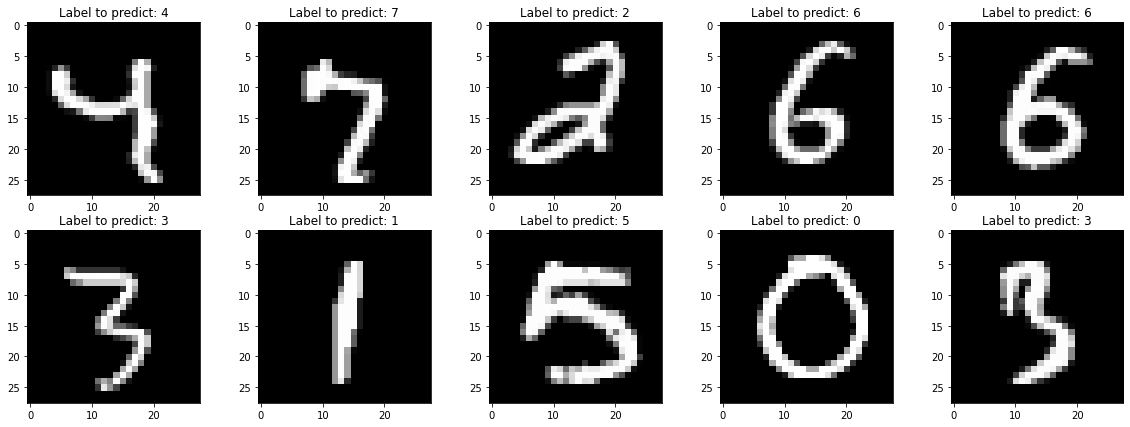

In [ ]:
n_images = 10
indices = np.random.randint(0, training_data.shape[0]-1,n_images)
fig, ax =plt.subplots(nrows=2,ncols=5,figsize=(20,7))
for i in range(n_images):
    ax[i//5,i%5].imshow(training_data[i].reshape(28, 28), cmap='gray')
    ax[i//5,i%5].set_title("Label to predict: {}".format(training_labels[i]))
plt.show()

### Third Step: Fit the model in a cross validation loop

Scikit-learn makes the use of cross validation very simple in many standard cases. It fits perfectly into the general pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 

There are different ways to do cross validation and we will discuss various options in a second. The easiest one is to specify a number (e.g. cv=5) which leads to totally random cross validation. 


In [ ]:
model = DecisionTreeClassifier()
scores = cross_val_score(model, training_data, training_labels, cv=5)
print("Accuracy per run: ",scores,"Average Accuracy: ", np.mean(scores),"Standard Deviation: ", np.std(scores))

Accuracy per run:  [0.73142857 0.75714286 0.75857143 0.75285714 0.76571429] Average Accuracy:  0.7531428571428571 Standard Deviation:  0.011619828232950137


## Proper Cross Validation:
Cross-validation and proper train test splitting is probably one of the most important parts in application oriented machine learning! It is often tempting to do it improperly, but can lead to very wrong application of the trained model.

One *correct* way of cross validation is:
1. Understand the structure of the dataset
2. Understand what the target "generalization" step of the approach should be
3. Check if a fitting method already exists in https://scikit-learn.org/stable/modules/cross_validation.html, if yes use it. If no -> implement yourself (can be a bit advanced) 


#### `TODO`: are you cross-validation master? 

For the following scenarios consider what is the right way to split your data  for cross validation and for the hold out test set. 

1. You learn a model to classify (detect) heart rythm disorder in a new patient based on ECG signals from different days. 
![](https://drive.google.com/uc?export=view&id=1BAtx1spZX_OCSfT0qTg8TQZe9R222wve)
2. You learn a model to predict the bitcoin price on the next day.
![](https://drive.google.com/uc?export=view&id=13SMpn2Ohbw-RCtEmg8d1JeiIXci1ot6B)
3. You learn a model for human face classification (e.g. person with beard/ person without beard). 
![](https://drive.google.com/uc?export=view&id=1Duxe7Nxtlh5YPcMdlGRe3OZRuEHmP9-a)
4. Data with severe group imbalance (we will look at this problem from a coding perspective).

#### Example: Cross validation with severe group imbalance
We create a setting where most of the data are ones and only very few image are zeros. Often classification settings are imbalanced:
- fault detection (machines usually work, they are broken very rarely)
- disease detection (most people are healthy, only some have certain disease)
- ... 

In [ ]:
# Prepare our imbalanced data setting:
imbalanced_label=np.concatenate([training_labels[training_labels=="0"][:6],training_labels[training_labels=="1"]])
imbalanced_data=np.concatenate([training_data[training_labels=="0"][:6],training_data[training_labels=="1"]])
print(np.unique(imbalanced_label,return_counts=True))

(array(['0', '1'], dtype=object), array([  6, 383]))


Analyze what happens if we do standard K-Fold cross validation

In [ ]:
kf = KFold(n_splits=5)
model = DecisionTreeClassifier()
scores = cross_val_score(model, imbalanced_data, imbalanced_label, cv=kf,scoring="balanced_accuracy")
print("Accuracy per run: ",scores,"Average Accuracy: ", np.mean(scores),"Standard Deviation: ", np.std(scores))

Accuracy per run:  [0.5        1.         1.         1.         0.98701299] Average Accuracy:  0.8974025974025974 Standard Deviation:  0.1987649503346389


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Analyze what happens if we do Stratified K-Fold cross validation (having approximately the same proportion of data in training and validation data)

In [ ]:
skf = StratifiedKFold(n_splits=5)
model = DecisionTreeClassifier()
scores = cross_val_score(model, imbalanced_data, imbalanced_label, cv=skf,scoring="balanced_accuracy")
print("Accuracy per run: ",scores,"Average Accuracy: ", np.mean(scores),"Standard Deviation: ", np.std(scores))


Accuracy per run:  [0.75       0.5        0.5        1.         0.99342105] Average Accuracy:  0.7486842105263157 Standard Deviation:  0.22214641674110822


#### `TODO`: Discuss the differences, which approach is better? 

### Model selection: The best model for digit classification

We want to analyze two models, first random forests and second support vector machines. Both have quite a few hyperparameters and we focus on one for each model (one that has a large influence usually).

We want to find, the best model with the best hyperparameter configuration:

In [ ]:
# We want to check this three values for the number of estimators (numbers of trees in the forest)
n_estimators = [5, 10, 100]
# We want to collect the scores:
scores_rf = []
for i in n_estimators:
  rf = RandomForestClassifier(n_estimators=i)
  scores_rf.append(cross_val_score(rf,training_data,training_labels,cv=5))


In [ ]:
scores_rf=np.array(scores_rf)
# The average performance is usually the most imprtant decision criterium in model selection
print("Mean performance of the three hyperparams: ", np.mean(scores_rf,axis=1))
# Sometimes the variance (or standard deviation) is relevant too, to see if the splits have very different dificulity.
print("Standard deviation of the three hyperparams: ", np.std(scores_rf,axis=1))

Mean performance of the three hyperparams:  [0.82085714 0.87228571 0.932     ]
Standard deviation of the three hyperparams:  [0.00945883 0.00714857 0.0024908 ]


#### `TODO`: Implement the same search over different kernels for a SVM classifier

In [ ]:
# Insert your code here! Do the same for SVM as we did for random forest!
kernels = ['linear', 'sigmoid', 'rbf']
scores_svm = []

#### Analyze the results / Compare the methods
Sometimes a plot can help to get an additional perspective, see the size of the difference between models etc. Often it is also misleading, one should always try to understand values and plots. 

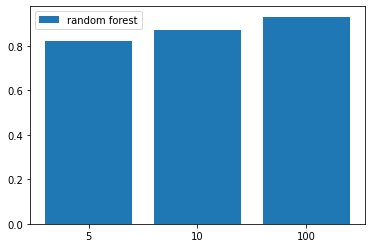

In [ ]:
n_estimators = [str(num) for num in n_estimators]
plt.bar(n_estimators, np.mean(scores_rf,axis=1), label='random forest')
plt.legend()

In [ ]:
plt.bar(kernels, np.mean(scores_svm,axis=1), label='svm')
plt.legend()

### Evaluate on the test set:
- Which model would you select, which hp and why ? 
- Once you are crossing this boarder there is no statistically clean way back (even though practitioners do it often)

In [ ]:
# Retrain on the whole training set with the parameter that you chose

In [ ]:
# Check the performance by testing on the test set